Figure saved as PNG at: /Users/patrick_bloniasz/filtered-point-process/static/forward_model_example.png


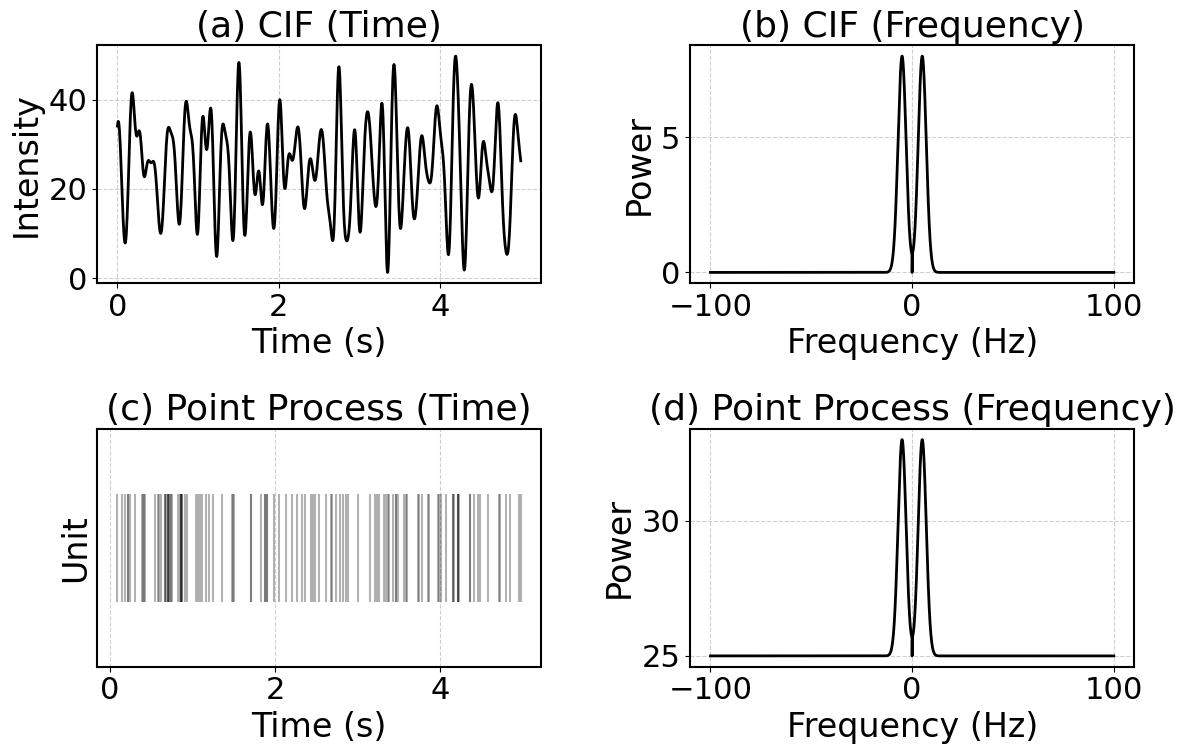

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from filtered_point_process.model import Model

# ----------------------------------------------------------------------
# 1) Matplotlib & style settings
# ----------------------------------------------------------------------
plt.rcParams.update({
    'axes.linewidth': 1.5,
    'grid.alpha': 0.6,
    'grid.linestyle': '--',
    'font.size': 22,
    'axes.titlesize': 26,
    'axes.labelsize': 24,
    'legend.fontsize': 22,
    'xtick.labelsize': 22,
    'ytick.labelsize': 22,
    'savefig.dpi': 500  # Output resolution
})
palette = ['black', 'gray', 'darkgray', 'lightgray']
time_domain_color = palette[0]
freq_domain_color = palette[0]
spike_color = palette[0]

# ----------------------------------------------------------------------
# 2) Define model & simulation parameters
# ----------------------------------------------------------------------
model_name = "gaussian"
model_params = {
    "peak_height": [8],
    "center_frequency": [5],   # Hz
    "peak_width": [2],        # Hz
    "lambda_0": [25],
}
simulation_params = {
    "fs": 200,    # Sampling frequency (Hz)
    "T": 5,       # Total time (s)
    "simulate": True,
    "seed": 1,    # For reproducibility
}

# 3) Create and simulate the model
model = Model(model_name, model_params, simulation_params)
spikes = model.spikes

# 4) Access CIF outputs
time_axis = model.cif.cif_time_axis
intensity = model.cif.cif_realization.squeeze()
freqs_cif = model.cif.frequencies
psd_cif = model.cif.PSD

# 5) Compute point-process spectrum 
pp_psd = model.pp.frequency_domain.get_PSD()

# ----------------------------------------------------------------------
# 6) Single Figure, 2 x 2 subplots
# ----------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Top-Left: CIF in time domain
axes[0, 0].plot(time_axis, intensity, color=time_domain_color, lw=2)
axes[0, 0].set_title("(a) CIF (Time)")
axes[0, 0].set_xlabel("Time (s)")
axes[0, 0].set_ylabel("Intensity")
axes[0, 0].grid(True)

# Top-Right: CIF in frequency domain
axes[0, 1].plot(freqs_cif, psd_cif, color=freq_domain_color, lw=2)
axes[0, 1].set_title("(b) CIF (Frequency)")
axes[0, 1].set_xlabel("Frequency (Hz)")
axes[0, 1].set_ylabel("Power")
axes[0, 1].grid(True)

# Bottom-Left: Spike train (event plot)
axes[1, 0].eventplot(spikes, colors=spike_color, alpha=0.3)
axes[1, 0].set_title("(c) Point Process (Time)")
axes[1, 0].set_xlabel("Time (s)")
axes[1, 0].set_yticks([])
axes[1, 0].set_ylabel("Unit")
axes[1, 0].grid(True)

# Bottom-Right: Spike train spectrum 
axes[1, 1].plot(freqs_cif, pp_psd, color=spike_color, lw=2)
axes[1, 1].set_title("(d) Point Process (Frequency)")
axes[1, 1].set_xlabel("Frequency (Hz)")
axes[1, 1].set_ylabel("Power")
axes[1, 1].grid(True)

plt.tight_layout()


# Define the directory and filename
save_dir = "/Users/patrick_bloniasz/filtered-point-process/static"
filename = "forward_model_example.png"  

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)

# Full path for saving
save_path = os.path.join(save_dir, filename)

# Save the figure as a PNG (replace 'fig' with your figure object)
plt.savefig(save_path, format='png', dpi=500, bbox_inches="tight")

print(f"Figure saved as PNG at: {save_path}")

plt.show()


/Users/patrick_bloniasz/miniforge3/envs/filtered-point-process/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Theoretical Rate (lambda_0): 1000
Estimated Rate (lambda_0):   1006.305
Gamma Dispersion (phi):      0.192
Gamma Shape (k):             5.212
Gamma Scale:                 37.050
Figure saved as PNG at: /Users/patrick_bloniasz/filtered-point-process/static/estimation_example.png


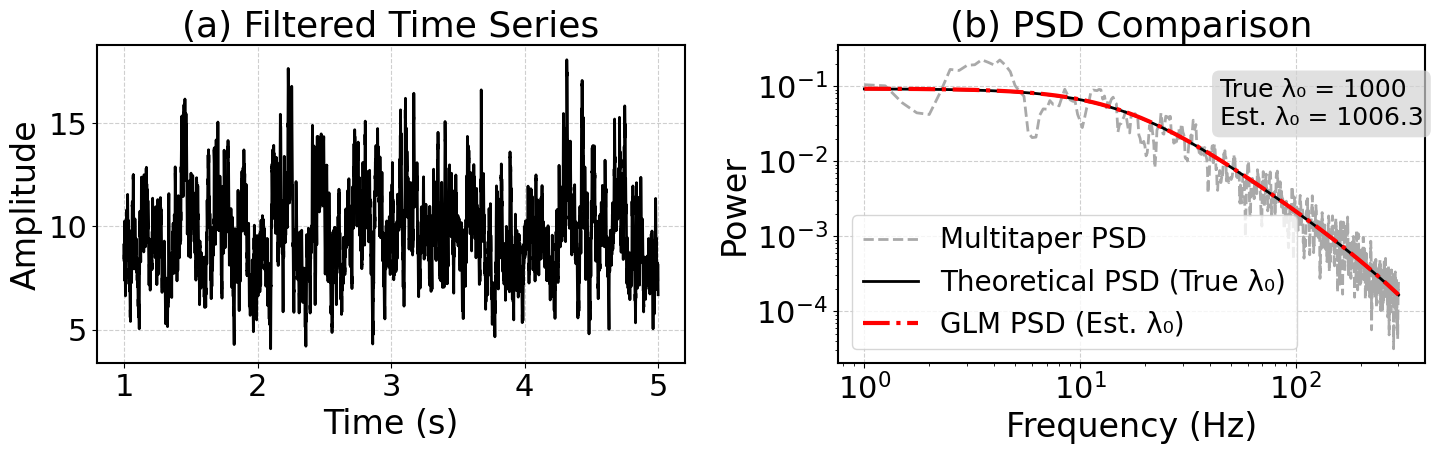

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Filtered Point Process imports
from filtered_point_process.model import Model
from filtered_point_process.point_processes.filtered_point_process import FilteredPointProcess
from spectral_connectivity import Multitaper, Connectivity

# ----------------------------------------------------------------------
# 1) Matplotlib & style settings
# ----------------------------------------------------------------------
plt.rcParams.update({
    'axes.linewidth': 1.5,
    'grid.alpha': 0.6,
    'grid.linestyle': '--',
    'font.size': 22,
    'axes.titlesize': 26,
    'axes.labelsize': 24,
    'legend.fontsize': 20,
    'xtick.labelsize': 22,
    'ytick.labelsize': 22,
    'savefig.dpi': 500  # Output resolution
})

# Color palette
palette = ['black', 'gray', 'darkgray', 'lightgray']
time_series_color = palette[0]    # Black for time series
theoretical_color = palette[0]    # Gray for theoretical PSD
multitaper_color = palette[2]     # Dark gray for multitaper PSD
estimated_color = 'red'           # Red for GLM PSD (estimated)

# ----------------------------------------------------------------------
# 2) Step 1 & 2: Setup Simulation Parameters
# ----------------------------------------------------------------------
fs = 10_000          # Sampling frequency (Hz)
T = 5                # Duration of simulation (s)
lambda_0 = 1_000       # Poisson rate (Hz)
seed = 44            # Random seed

model_params = {"lambda_0": lambda_0}
simulation_params = {"fs": fs, "T": T, "simulate": True, "seed": seed}

# Create a Homogeneous Poisson model and apply a GABA filter
model = Model("homogeneous_poisson", model_params, simulation_params)
filters = {"GABA": "GABA"}
fpp = FilteredPointProcess(filters=filters, model=model)
fpp.apply_filter_sequences([["GABA"]])

# ----------------------------------------------------------------------
# 3) Retrieve Time Series & Kernel Spectrum
# ----------------------------------------------------------------------
burn_in = fs
filtered_time_series = fpp.final_time_series[burn_in:]
time_axis = np.linspace(0, T, len(fpp.final_time_series))[burn_in:]

gaba_filter = fpp.filter_instances["GABA"]
full_kernel_spectrum = gaba_filter.kernel_spectrum
theoretical_frequencies = model.frequencies
theoretical_psd = full_kernel_spectrum * lambda_0

# ----------------------------------------------------------------------
# 4) Multitaper PSD Estimation
# ----------------------------------------------------------------------
n_tapers = 7
multitaper = Multitaper(
    filtered_time_series,
    sampling_frequency=fs,
    n_tapers=n_tapers,
    start_time=time_axis[0],
)
connectivity = Connectivity.from_multitaper(multitaper)

multitaper_psd = connectivity.power().squeeze()
multitaper_frequencies = connectivity.frequencies

# ----------------------------------------------------------------------
# 5) Restrict to Positive Frequency Range & Interpolate Theoretical PSD
# ----------------------------------------------------------------------
freq_min, freq_max = 1, 300
valid_theory_idx = np.where(
    (theoretical_frequencies >= freq_min) & (theoretical_frequencies <= freq_max)
)
freqs_pos = theoretical_frequencies[valid_theory_idx]
S_psp_pos = full_kernel_spectrum[valid_theory_idx]

valid_mtap_idx = np.where(
    (multitaper_frequencies >= freq_min) & (multitaper_frequencies <= freq_max)
)
multitaper_frequencies_filtered = multitaper_frequencies[valid_mtap_idx]
multitaper_psd_filtered = multitaper_psd[valid_mtap_idx]

# Interpolate theoretical PSD to match multitaper freq axis
S_psp_interpolated = np.interp(
    multitaper_frequencies_filtered, freqs_pos, S_psp_pos
)

# ----------------------------------------------------------------------
# 6) Fit Gamma GLM (Identity Link)
# ----------------------------------------------------------------------
X = S_psp_interpolated.reshape(-1, 1)  # Theoretical PSD as predictor
y = multitaper_psd_filtered            # Multitaper PSD as response

glm_model = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.identity()))
glm_results = glm_model.fit()

lambda_0_estimated = glm_results.params[0]
phi = glm_results.scale
k = 1 / phi

# ----------------------------------------------------------------------
# 7) Print Results
# ----------------------------------------------------------------------
print(f"Theoretical Rate (lambda_0): {lambda_0}")
print(f"Estimated Rate (lambda_0):   {lambda_0_estimated:.3f}")
print(f"Gamma Dispersion (phi):      {phi:.3f}")
print(f"Gamma Shape (k):             {k:.3f}")
print(f"Gamma Scale:                 {phi * lambda_0_estimated / k:.3f}")

# Predicted Spectrum from GLM
glm_predicted_psd = S_psp_interpolated * lambda_0_estimated

# ----------------------------------------------------------------------
# 8) Single Figure with 2 Subplots
# ----------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# (a) Filtered Time Series (Burn-in Removed)
axes[0].plot(time_axis, filtered_time_series, color=time_series_color, lw=2)
axes[0].set_title("(a) Filtered Time Series")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Amplitude")
axes[0].grid(True)

# (b) PSD Comparison
axes[1].loglog(
    multitaper_frequencies_filtered,
    multitaper_psd_filtered,
    label="Multitaper PSD",
    linewidth=2,
    linestyle="--",
    color=multitaper_color
)
axes[1].loglog(
    freqs_pos,
    S_psp_pos * lambda_0,
    label="Theoretical PSD (True λ₀)",
    linewidth=2,
    color=theoretical_color
)
axes[1].loglog(
    multitaper_frequencies_filtered,
    glm_predicted_psd,
    label="GLM PSD (Est. λ₀)",
    linestyle="-.",
    linewidth=3,
    color=estimated_color
)
axes[1].set_title("(b) PSD Comparison")
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("Power")
axes[1].grid(True)

# Show True vs. Estimated λ₀ on the plot
axes[1].text(
    0.65, 0.75,
    f"True λ₀ = {lambda_0}\nEst. λ₀ = {lambda_0_estimated:.1f}",
    transform=axes[1].transAxes,
    fontsize=18,
    bbox=dict(boxstyle="round,pad=0.3", fc="lightgray", ec="none", alpha=0.7)
)

axes[1].legend(loc="best")
plt.tight_layout()


import os

# Define the directory and filename
save_dir = "/Users/patrick_bloniasz/filtered-point-process/static"
filename = "estimation_example.png"  

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)

# Full path for saving
save_path = os.path.join(save_dir, filename)

# Save the figure as a PNG (replace 'fig' with your figure object)
plt.savefig(save_path, format='png', dpi=500, bbox_inches="tight")

print(f"Figure saved as PNG at: {save_path}")

plt.show()